In [93]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pandas as pd
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import os
from astropy.coordinates import SkyCoord
import astropy.units as u



In [94]:
hdul = fits.open('C:/Users/Admin/Desktop/Data Science/parallax/random10000parallax.fits')
hdul.info()
data = hdul[1].data


Filename: C:/Users/Admin/Desktop/Data Science/parallax/random10000parallax.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  votable       1 BinTableHDU    168   10000R x 30C   [26A, K, D, E, D, E, D, D, D, E, E, D, E, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [95]:
table = Table.read('C:/Users/Admin/Desktop/Data Science/parallax/random10000parallax.fits')
table.colnames
table['parallax'].unit
parallax = data['parallax']
parallax_error = data['parallax_error']
distance = data['distance_gspphot']
distance_error = data['distance_gspphot_upper'] - data['distance_gspphot_lower']


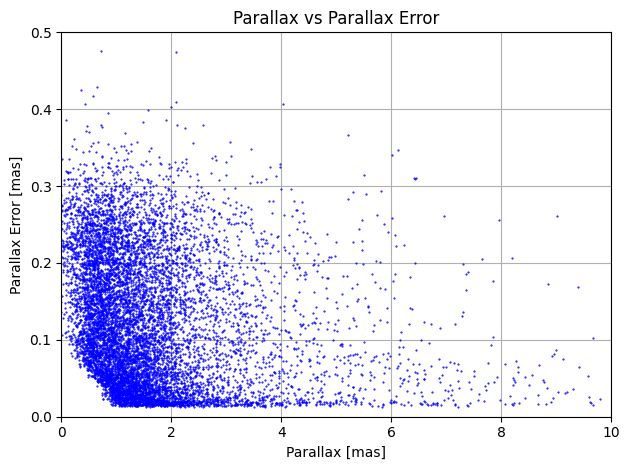

In [150]:
plt.plot(parallax, parallax_error, 'b.', markersize=1)
plt.xlabel('Parallax [mas]')
plt.ylabel('Parallax Error [mas]')
plt.xlim(0, 10)
plt.ylim(0, 0.5)
plt.title('Parallax vs Parallax Error')
plt.tight_layout()
plt.grid(True)
plt.show()


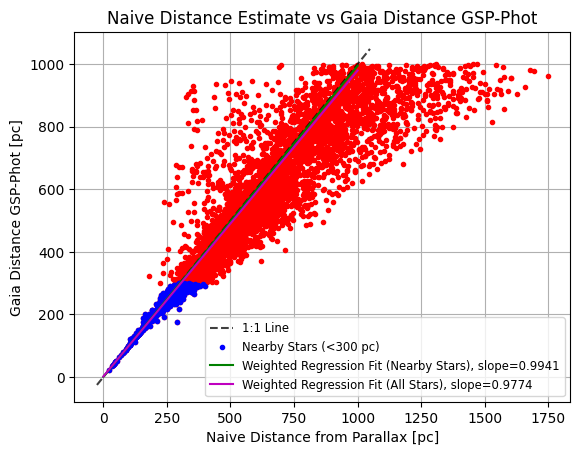

In [190]:
#estiomate naive distances from parallax
distance_naive = 1000 / parallax  # in parsecs
#estimate uncertainties in naive distances using error propagation
distance_naive_error = (parallax_error / parallax**2) * 1000  # in parsecs
#exclude gaussian errors in parallax and only use naive distances if snr > 10
snr = parallax / parallax_error #snr = signal to noise ratio
distance_naive_filtered = np.where(snr > 10, distance_naive, np.nan) #only use distances where snr > 10
distance_naive_error_filtered = np.where(snr > 10, distance_naive_error, np.nan) #only use errors where snr > 10
#include zero point offset of -0.029 mas in parallax measurements
parallax_zero_point = -0.029  # in mas
parallax_corrected = parallax - parallax_zero_point
distance_naive_corrected = 1000 / parallax_corrected  # in parsecs
distance_naive_corrected_error = (parallax_error / parallax_corrected**2) * 1000  # in parsecs
distance_naive_corrected_filtered = np.where(snr > 10, distance_naive_corrected, np.nan) #only use distances where snr > 10

#plot naive distances vs given gaia distances
plt.plot(distance_naive_corrected_filtered, distance, 'r.')
plt.xlabel('Naive Distance from Parallax [pc]')
plt.ylabel('Gaia Distance GSP-Phot [pc]')
plt.title('Naive Distance Estimate vs Gaia Distance GSP-Phot')

#plot one to one line given relative max distances on axes
lims = [max(plt.xlim()[0], plt.ylim()[0]), min(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, 'k--', alpha=0.75, zorder=2, label='1:1 Line')

#plot blue points for nearby stars (gaia distance < 300pc) where Gaia parallaxes are more reliable
nearby_mask = (distance < 300) & \
                np.isfinite(distance) & \
                np.isfinite(distance_naive_corrected_filtered)
plt.plot(distance_naive_corrected_filtered[nearby_mask], distance[nearby_mask], 'b.', label='Nearby Stars (<300 pc)')

#uncertainty weighted regression fit 
def linear_model(x, m, b):
    return m * x + b
def weighted_residuals(params, x, y, y_err):
    m, b = params
    model = linear_model(x, m, b)
    return (y - model) / y_err

#for nearby stars
initial_params = [1.0, 0.0]
y_err_nearby = distance_error[nearby_mask] #uncertainties in gaia distances for nearby stars
x_nearby = distance_naive_corrected_filtered[nearby_mask] #naive distances for nearby stars
y_nearby = distance[nearby_mask] #gaia distances for nearby stars
result = optimize.least_squares(weighted_residuals, initial_params, args=(x_nearby, y_nearby, y_err_nearby)) #optimize
m_fit, b_fit_fit = result.x
x_fit = np.linspace(0, 1000, 100)
y_fit = linear_model(x_fit, m_fit, b_fit_fit)
plt.plot(x_fit, y_fit, 'g-', label='Weighted Regression Fit (Nearby Stars), slope={:.4f}'.format(m_fit))

#for all stars
y_err = distance_error[np.isfinite(distance_naive_corrected_filtered)] #uncertainties in gaia distances for all stars
x_all = distance_naive_corrected_filtered[np.isfinite(distance_naive_corrected_filtered)] #naive distances for all stars
y_all = distance[np.isfinite(distance_naive_corrected_filtered)] #gaia distances for all stars
result_all = optimize.least_squares(weighted_residuals, initial_params, args=(x_all, y_all, y_err)) #optimize
m_fit_all, b_fit_all = result_all.x
x_fit_all = np.linspace(0, 1000, 100)
y_fit_all = linear_model(x_fit_all, m_fit_all, b_fit_all)
plt.plot(x_fit_all, y_fit_all, 'm-', label='Weighted Regression Fit (All Stars), slope={:.4f}'.format(m_fit_all))
plt.grid(True)



plt.legend(fontsize='small')




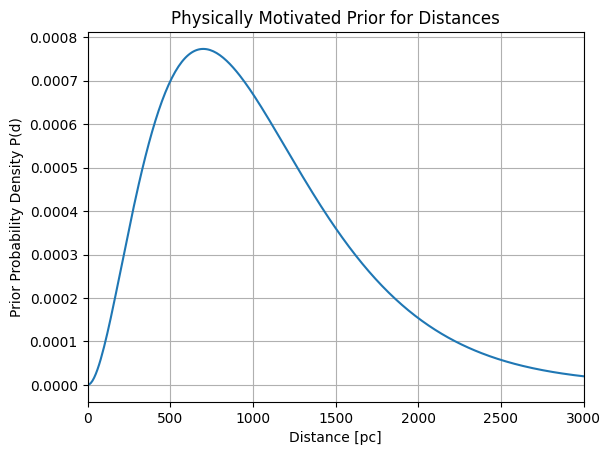

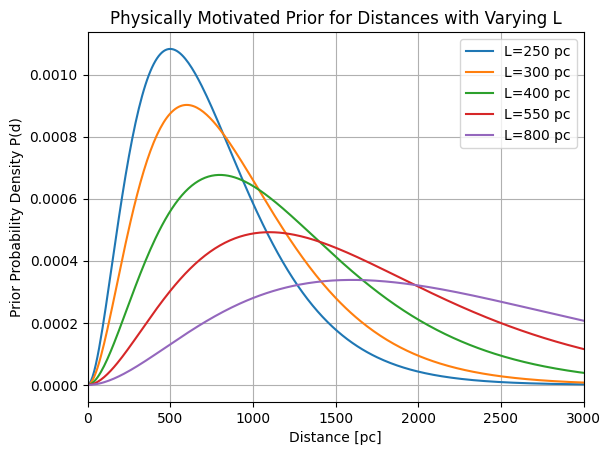

In [191]:
#define physically motivated prior for distances
#P(d) = (1/2L^3) * d^2 * exp(-d/L) for d >= 0, else 0
d = distance
L = 350  # scale length in parsecs
Prior = lambda d: (1 / (2 * L**3)) * d**2 * np.exp(-d / L) * (d >= 0)

#plot prior
plt.figure()
d_values = np.linspace(0, 10000, 1000)  
plt.plot(d_values, Prior(d_values))
plt.xlabel('Distance [pc]')
plt.xlim(0, 3000)
plt.ylabel('Prior Probability Density P(d)')
plt.title('Physically Motivated Prior for Distances')
plt.grid(True)
plt.show()

#plot different plots for values of L= 250, 300, 400, 550, 800
L_values = [250, 300, 400, 550, 800]
for L in L_values:
    Prior_L = lambda d: (1 / (2 * L**3)) * d**2 * np.exp(-d / L) * (d >= 0)
    plt.plot(d_values, Prior_L(d_values), label=f'L={L} pc')
plt.xlabel('Distance [pc]')
plt.xlim(0, 3000)
plt.ylabel('Prior Probability Density P(d)')
plt.title('Physically Motivated Prior for Distances with Varying L')
plt.grid(True)
plt.legend()
plt.show()



Sample Star Parallax:  0.4249749771504553  mas
Sample Star distance GSP-Phot:  917.9784  pc


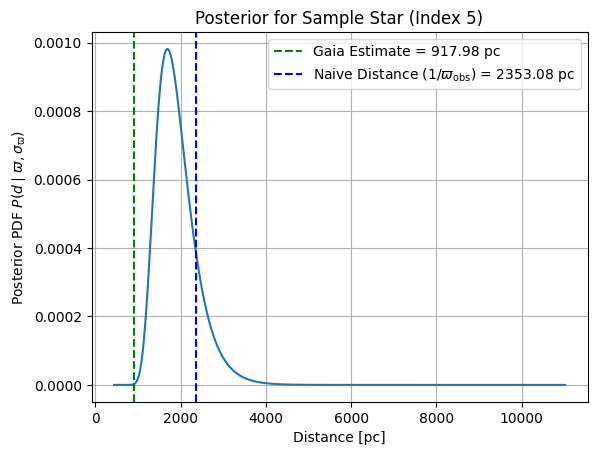

In [ ]:
#define posterior for distance given parallax measurement
#P(d|p, σ_p) ∝ P(p|d, σ_p) * P(d)
#the posterior is proportional to (d^2e^-d/L)/sigma_p * exp(-(p - p(zeropoint) -  1/d)^2 / (2σ_p^2))
d = distance
p = parallax
σ_p = parallax_error
p_zeropoint = -0.029

def Posterior(d, p, σ_p, L=350, p_zeropoint=-0.029):
    likelihood = (1 / (np.sqrt(2 * np.pi) * σ_p)) * np.exp(-0.5 * ((p - p_zeropoint - 1000 / d) / σ_p)**2)
    prior = (1 / (2 * L**3)) * d**2 * np.exp(-d / L) * (d >= 0)
    return likelihood * prior

#plot the posterior for a sample star over a range of distances given the distance estimate from gaia
sample_index = 5  # index of the sample star
print(r"Sample Star Parallax: ", p[sample_index], " mas")
print(r"Sample Star distance GSP-Phot: ", distance[sample_index], " pc")
d0 = 1000/ max(p[sample_index] - p_zeropoint, 0.1)  #initial distance guess based on parallax
d_range = np.linspace(0.2*d0, 5*d0, 500)  # distance range centred on parallax distance estimate
# distance range from 0.1 to 1000 pc
posterior = Posterior(d_range, p[sample_index], σ_p[sample_index])
#normalize the posterior for plotting
posterior /= np.trapezoid(posterior, d_range)

plt.figure()
plt.plot(d_range, posterior)
plt.xlabel(r'Distance [pc]')
plt.ylabel(r'Posterior PDF $P(d \mid \varpi, \sigma_{\mathrm{\varpi}})$')
plt.title(r'Posterior for Sample Star (Index {})'.format(sample_index))


#sanity check: mark the gaia distance estimate and naive distance on the plot
plt.axvline(
    distance[sample_index],
    color='g',
    linestyle='--',
    label=fr'Gaia Estimate = {distance[sample_index]:.2f} pc'
)

plt.axvline(
    1000 / p[sample_index],
    color='b',
    linestyle='--',
    label=fr'Naive Distance ($1/\varpi_{{\mathrm{{obs}}}}$) = {(1000 / p[sample_index]):.2f} pc'
)


plt.legend()

plt.grid(True)
plt.show()






In [100]:
#convert ra, dec to galactic coordinates
coords = SkyCoord(ra=data['ra']*u.degree, dec=data['dec']*u.degree, frame='icrs')
l = coords.galactic.l.degree
b = coords.galactic.b.degree



In [101]:
#approximate L(l,b) piewcewise

def L_lb(l, b):
    b = np.abs(b)
    if b < 30:
        return 800
    elif b < 35:
        return 550
    elif b < 40:
        return 400
    elif b < 45:
        return 300
    else:
        return 250

Sample Star Parallax:  0.4249749771504553  mas
Sample Star distance GSP-Phot:  917.9784  pc


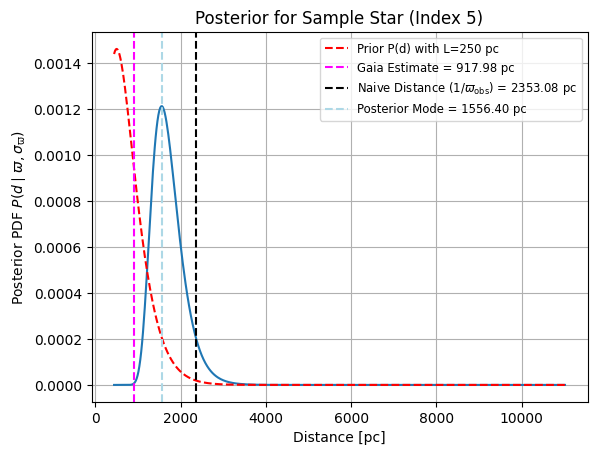

In [167]:
#plot the posterior for a sample star over a range of distances given the distance estimate from gaia with L(l,b)
L_star = L_lb(l[sample_index], b[sample_index])

def Posterior(d, p, σ_p, L=L_star, p_zeropoint=-0.029):
    likelihood = (1 / (np.sqrt(2 * np.pi) * σ_p)) * np.exp(-0.5 * ((p - p_zeropoint - 1000 / d) / σ_p)**2)
    prior = (1 / (2 * L_star**3)) * d**2 * np.exp(-d / L_star) * (d >= 0)
    return likelihood * prior


print(r"Sample Star Parallax: ", p[sample_index], " mas")
print(r"Sample Star distance GSP-Phot: ", distance[sample_index], " pc")
d0 = 1000/ max(p[sample_index] - p_zeropoint, 0.1)  #initial distance guess based on parallax
d_range = np.linspace(0.2*d0, 5*d0, 500)  # distance range centred on parallax distance estimate
# distance range from 0.1 to 1000 pc
posterior = Posterior(d_range, p[sample_index], σ_p[sample_index], L=L_star, p_zeropoint=-0.029)
#normalize the posterior for plotting
posterior /= np.trapezoid(posterior, d_range)



plt.figure()
plt.plot(d_range, 
        posterior)

plt.xlabel(r'Distance [pc]')
plt.ylabel(r'Posterior PDF $P(d \mid \varpi, \sigma_{\mathrm{\varpi}})$')
plt.title(r'Posterior for Sample Star (Index {})'.format(sample_index))
#plot the prior alongside for comparison
prior = (1 / (2 * L_star**3)) * d_range**2 * np.exp(-d_range / L_star)
prior /= np.trapezoid(prior, d_range)
label_L = fr'Prior P(d) with L={L_star} pc'
#add label with L value into the legend
plt.plot(d_range,
        prior, 'r--', 
        label=label_L,
)
plt.legend()

#sanity check: mark the gaia distance estimate and naive distance on the plot
plt.axvline(
    distance[sample_index],
    color='magenta',
    linestyle='--',
    label=fr'Gaia Estimate = {distance[sample_index]:.2f} pc'
)

plt.axvline(
    1000 / p[sample_index],
    color='black',
    linestyle='--',
    label=fr'Naive Distance ($1/\varpi_{{\mathrm{{obs}}}}$) = {(1000 / p[sample_index]):.2f} pc'
)

#calculate the mode of the posterior distribution i.e. where the derivative is zero and mark it on the plot
def negative_posterior(d):
    return -Posterior(d, p[sample_index], σ_p[sample_index], L=L_star, p_zeropoint=-0.029)
mode_result = optimize.minimize_scalar(negative_posterior, bounds=(0.1, 1000/max(p[sample_index] - p_zeropoint, 0.1)), method='bounded')
plt.axvline(
    mode_result.x,
    color='lightblue',
    linestyle='--',
    label=fr'Posterior Mode = {mode_result.x:.2f} pc'
)   


#place legend top left
plt.legend(loc='upper right', fontsize='small')

plt.grid(True)
plt.show()

In [179]:
#calculate posterior modal distance (for both posterior choices), naive distance estimates for all stars and save them 
modes_posterior = []

distance_naive_all = []
print("max gaia distance: ", max(distance))
for i in range(len(p)):
    L_star = L_lb(l[i], b[i])
    
    #Posterior 1
    def negative_posterior(d):
        return -Posterior(d, p[i], σ_p[i], L=L_star, p_zeropoint=-0.029)
    mode_result1 = optimize.minimize_scalar(negative_posterior, bounds=(0.1, 1000/max(p[i] - -0.029, 0.1)), method='bounded')
    modes_posterior.append(mode_result1.x)
    
    
    distance_naive_all.append(1000 / p[i])  # in parsecs
    
#save results to the fits table
modes_posterior = np.array(modes_posterior)
distance_naive_all = np.array(distance_naive_all)
table['mode_posterior'] = modes_posterior
table['distance_naive'] = distance_naive_all

print(len(table), len(modes_posterior), len(distance_naive_all))

#table.write('C:/Users/Admin/Desktop/Data Science/parallax/random10000parallax.fits', overwrite=True)


    
    
    

max gaia distance:  999.7838
10000 10000 10000


In [180]:
#calculate median of posterior distribution (for both posterior choices)
medians_posterior = []


for i in range(len(p)):
    L_star = L_lb(l[i], b[i])
    d0 = 1000/ max(p[i] - p_zeropoint, 0.1)  #initial distance guess based on parallax
    d_range = np.linspace(0.2*d0, 5*d0, 500) 
    #Posterior 1
    posterior_dist1 = Posterior(d_range, p[i], σ_p[i], L=L_star, p_zeropoint=-0.029)
    posterior_dist1 /= np.trapezoid(posterior_dist1, d_range)
    cdf = np.cumsum(posterior_dist1)
    cdf /= cdf[-1]
    median_index1 = np.interp(0.5, cdf, d_range)
    medians_posterior.append(median_index1)
    

    
medians_posterior = np.array(medians_posterior)

table['median_posterior'] = medians_posterior


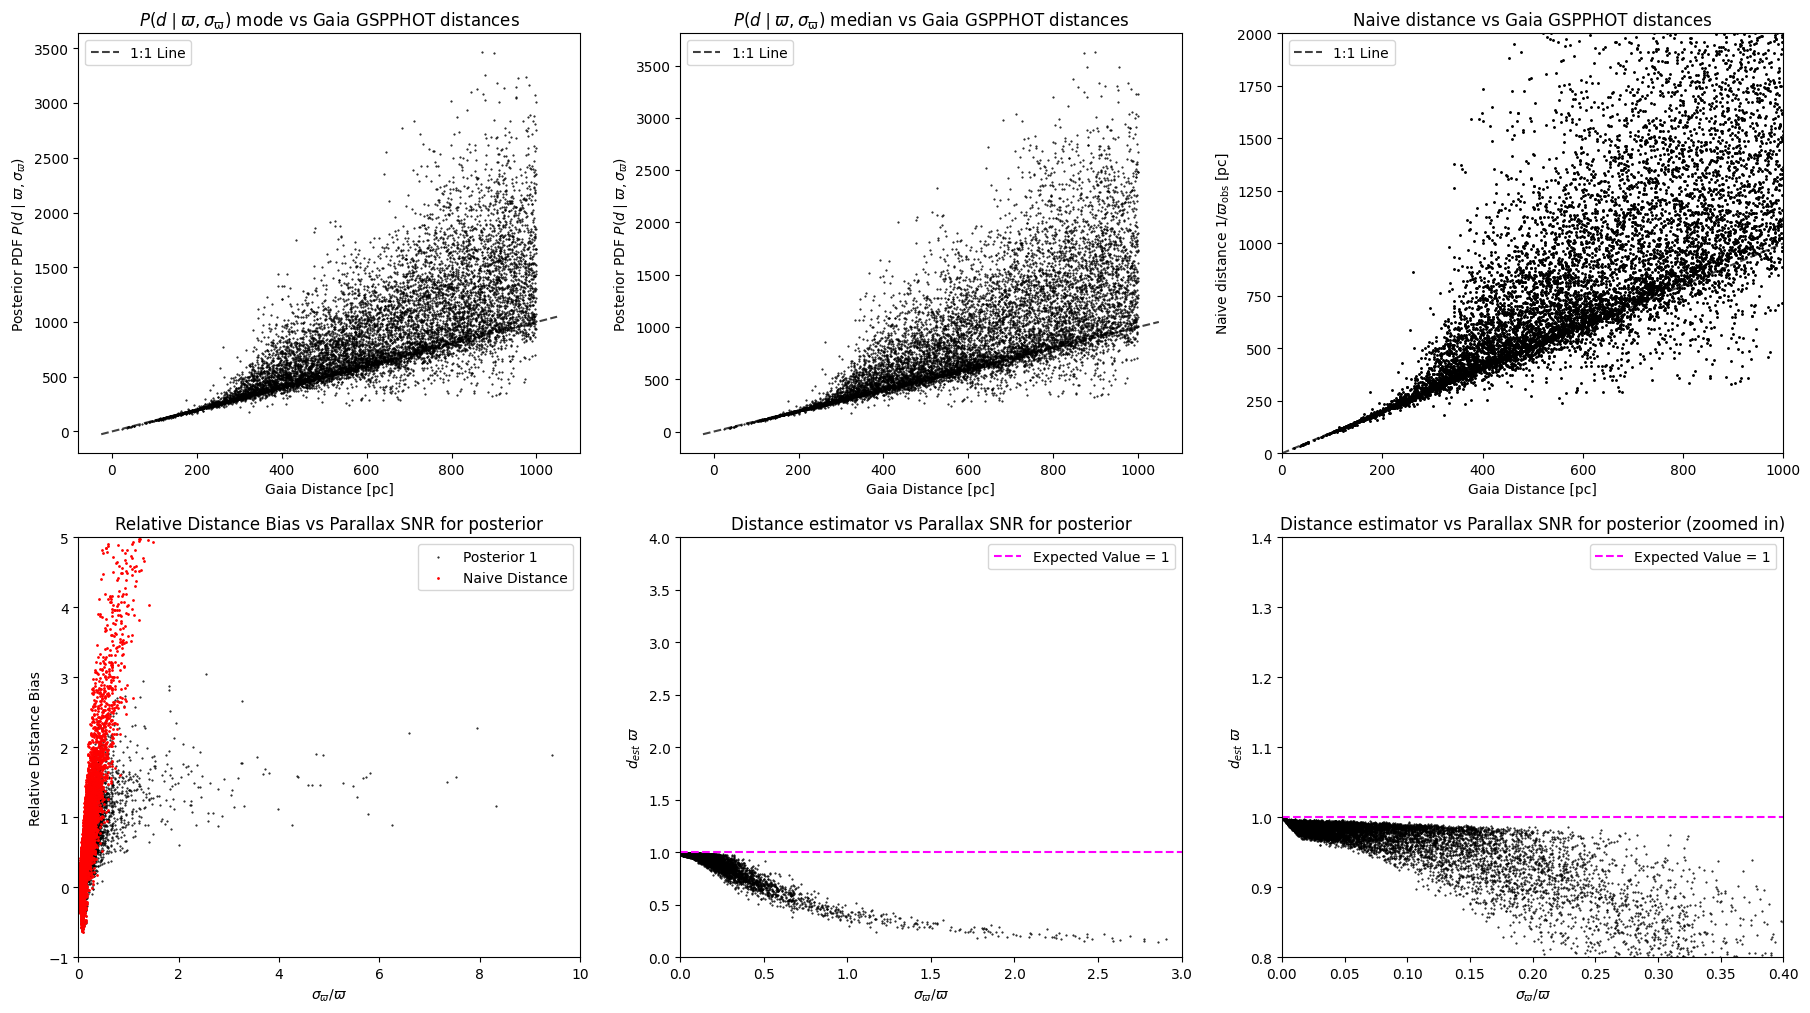

In [181]:
#various plots to compare posterior formulations
#posterior 1 vs posterior 2 for all 10000 stars 
#plot subplots in one figure

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
ax = axes[0, 0]  # first subplot
ax.scatter(
    distance,
    modes_posterior,
    color='black',
    s=1,
    marker='.'
)

#compute shared limits for 1:1 line
lims = [
    max(ax.get_xlim()[0], ax.get_ylim()[0]),
    min(ax.get_xlim()[1], ax.get_ylim()[1])
]

ax.plot(
    lims,
    lims,
    'k--',
    alpha=0.75,
    zorder=2,
    label='1:1 Line'
)

ax.set_xlabel(r'Gaia Distance [pc]')
ax.set_ylabel(r'Posterior PDF $P(d \mid \varpi, \sigma_{\varpi})$')
ax.set_title(r'$P(d \mid \varpi, \sigma_{\mathrm{\varpi}})$ mode vs Gaia GSPPHOT distances')
ax.legend()

ax = axes[0, 1]  # second subplot
ax.scatter(
    distance,
    medians_posterior,
    color='black',
    s=1,
    marker='.'
)

#compute shared limits for 1:1 line
lims = [
    max(ax.get_xlim()[0], ax.get_ylim()[0]),
    min(ax.get_xlim()[1], ax.get_ylim()[1])
]

ax.plot(
    lims,
    lims,
    'k--',
    alpha=0.75,
    zorder=2,
    label='1:1 Line'
)

ax.set_xlabel(r'Gaia Distance [pc]')
ax.set_ylabel(r'Posterior PDF $P(d \mid \varpi, \sigma_{\varpi})$')
ax.set_title(r'$P(d \mid \varpi, \sigma_{\mathrm{\varpi}})$ median vs Gaia GSPPHOT distances')
ax.legend()

ax = axes[0, 2]  # third subplot
ax.scatter(
    distance,
    distance_naive_all,
    color='black',
    s=1,
    marker='.'
)

#compute shared limits for 1:1 line
x_max = 1000
y_max = 2000
y_min = -2000
ax.scatter(distance, distance_naive_all, s=1, color='black')

ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)

line_max = min(x_max, y_max)
ax.plot([0, line_max], 
        [0, line_max],
        'k--', 
        alpha=0.75,
        zorder=2,
        label='1:1 Line')

ax.set_xlabel(r'Gaia Distance [pc]')
ax.set_ylabel(r'Naive distance $1/\varpi_{\mathrm{obs}}$ [pc]')
ax.set_title(r'Naive distance vs Gaia GSPPHOT distances')
ax.legend()

#ax = axes[1, 0]  # first subplot
#ax.scatter(
#    modes_posterior1,
#    modes_posterior2,
#    color='black',
#    s=1,
#    marker='.'
#)

#compute shared limits for 1:1 line
#lims = [
#    max(ax.get_xlim()[0], ax.get_ylim()[0]),
#    min(ax.get_xlim()[1], ax.get_ylim()[1])
#]

#ax.plot(
#    lims,
#    lims,
#    'k--',
#    alpha=0.75,
#    zorder=2,
#    label='1:1 Line'
#)

#ax.set_xlabel(r'Posterior PDF $P_1(d \mid \varpi, \sigma_{\varpi})$')
#ax.set_ylabel(r'Posterior PDF $P_2(d \mid \varpi, \sigma_{\varpi})$')
#ax.set_title(r'$P_1(d)$ vs $P_2(d)$ distance PDFs')
#ax.legend()

#distance estimate x parallax: should be inversely proportional and equal to 1 when multiplied
estimator = modes_posterior * p / 1000 #dimensionless quantity
#snr: parallax error / parallax
snr_all = σ_p / p

ax = axes[1, 1]  


lims = [(0, 3), (0, 4)]

ax.scatter(
    snr_all,
    estimator,
    color='black',
    s=1,
    marker='.'
)
ax.set_xlim(lims[0])
ax.set_ylim(lims[1])
#set a horizontal line at y=1
ax.axhline(1, color='magenta', linestyle='--', label='Expected Value = 1')
ax.legend()    
ax.set_xlabel(r'$\sigma_{\varpi} / \varpi$')
ax.set_ylabel(r'$d_{est}$ $\varpi$')
ax.set_title(r'Distance estimator vs Parallax SNR for posterior')

ax = axes[1, 2]  # first subplot
lims = [(0, 0.4), (0.8, 1.4)]

ax.scatter(
    snr_all,
    estimator,
    color='black',
    s=1,
    marker='.'
)
ax.set_xlim(lims[0])
ax.set_ylim(lims[1])
ax.axhline(1, color='magenta', linestyle='--', label='Expected Value = 1')
ax.legend()    
ax.set_xlabel(r'$\sigma_{\varpi} / \varpi$')
ax.set_ylabel(r'$d_{est}$ $\varpi$')
ax.set_title(r'Distance estimator vs Parallax SNR for posterior (zoomed in)')

#distance bias vs snr plot
ax = axes[1, 0] 
distance_bias_naive = (distance_naive_all - distance) / distance  #relative distance bias for naive distances
distance_bias = (modes_posterior - distance) / distance  #relative distance bias for first posterior
ax.scatter(
    snr_all,
    distance_bias,
    color='black',
    s=1,
    marker='.',
    label='Posterior 1'
)
ax.scatter(
    snr_all,
    distance_bias_naive,
    color='red',
    s=1,
    marker='o',
    label='Naive Distance'
)
ax.set_xlim((0, 10))
ax.set_ylim((-1, 5))
ax.set_xlabel(r'$\sigma_{\varpi} / \varpi$')
ax.set_ylabel(r'Relative Distance Bias')
ax.set_title(r'Relative Distance Bias vs Parallax SNR for posterior')
ax.legend()



10000 10000


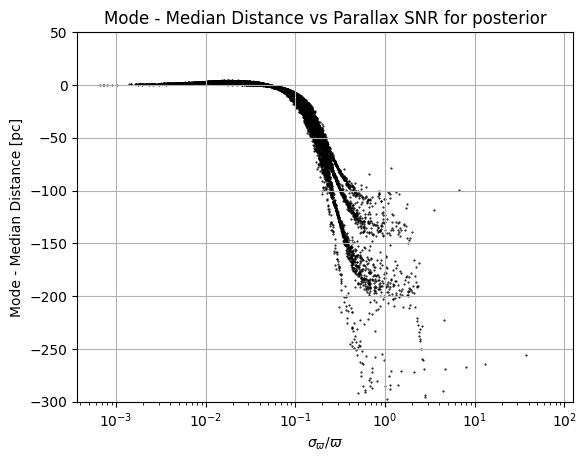

In [185]:
#plot mode-median vs SNR for both posterior choices
skewness1 = modes_posterior - medians_posterior
skewness3 = distance_naive_all - distance

snr = parallax_error / parallax

print(len(snr), len(skewness1))

plt.scatter(
    snr,
    skewness1,
    color='black',
    s=1,
    marker='.'
)
#plt.xlim((0, 2))
plt.xscale('log')
plt.ylim((-300, 50))
plt.xlabel(r'$\sigma_{\varpi} / \varpi$')
plt.ylabel(r'Mode - Median Distance [pc]')
plt.title(r'Mode - Median Distance vs Parallax SNR for posterior')
plt.grid(True)
plt.show()







In [107]:
#now instead of using the mode as the distance estimate, sample from the posterior using MCMC 
import emcee
import corner
import sys
!{sys.executable} -m pip install emcee
print("emcee version: ", emcee.__version__)
print("Python version: ", sys.version)
print(sys.executable)

emcee version:  3.1.6
Python version:  3.14.2 (tags/v3.14.2:df79316, Dec  5 2025, 17:18:21) [MSC v.1944 64 bit (AMD64)]
c:\Users\Admin\AppData\Local\Python\pythoncore-3.14-64\python.exe


Sample Star Parallax:  0.4249749771504553  mas
Sample Star distance GSP-Phot:  917.9784  pc


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:05<00:00, 365.16it/s]


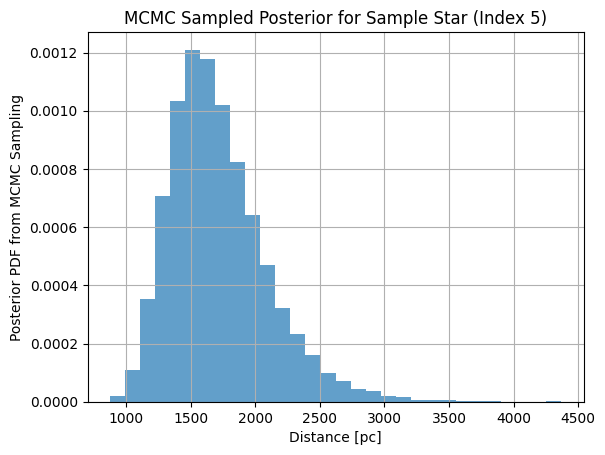

In [186]:
#sample the posterior for a sample star

def log_posterior(d, p, σ_p, L=L_star, p_zeropoint=-0.029):
    if d <= 0:
        return -np.inf  # log(0) for non-physical distances
    likelihood = -0.5 * ((p - p_zeropoint - 1000 / d) / σ_p)**2 - np.log(np.sqrt(2 * np.pi) * σ_p)
    prior = np.log((1 / (2 * L**3)) * d**2 * np.exp(-d / L))
    return likelihood + prior

print(r"Sample Star Parallax: ", p[sample_index], " mas")
print(r"Sample Star distance GSP-Phot: ", distance[sample_index], " pc")
#set up the MCMC sampler
ndim = 1  # number of parameters (distance)
nwalkers = 50  # number of walkers
initial_pos = distance[sample_index] + 10 * np.random.randn(nwalkers, ndim)  # initial positions
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(p[sample_index], σ_p[sample_index], L_lb(l[sample_index], b[sample_index]), -0.029))
#run the MCMC sampler
nsteps = 2000
sampler.run_mcmc(initial_pos, nsteps, progress=True)
#analyze the MCMC samples
samples = sampler.get_chain(discard=500, flat=True)  # discard burn-in samples
#plot the posterior samples
plt.figure()
plt.hist(samples, bins=30, density=True, alpha=0.7)
plt.xlabel('Distance [pc]')
plt.ylabel('Posterior PDF from MCMC Sampling')
plt.title(r'MCMC Sampled Posterior for Sample Star (Index {})'.format(sample_index))
plt.grid(True)
plt.show()




Median Distance from MCMC Samples:  1657.117155501226  pc
Mode Distance from MCMC Samples:  1548.9034815497143  pc
Naive Distance estimate:  2353.079719434791  pc
Analytical Mode Distance:  1563.5655597892355  pc
Analytical Median Distance:  1648.3212310144002  pc


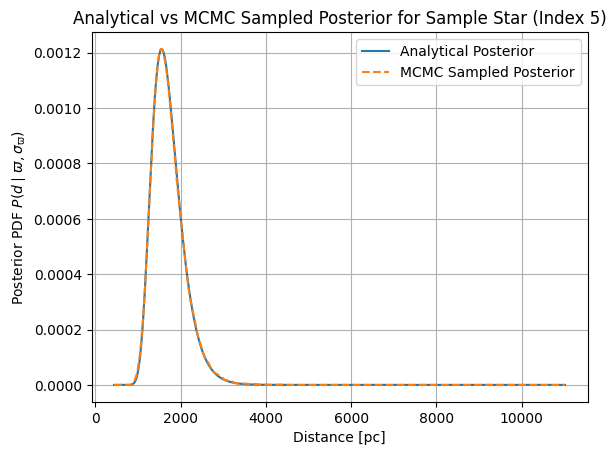

In [187]:
#calculate the median distance from the MCMC samples
median_distance_mcmc = np.median(samples)
print(r'Median Distance from MCMC Samples: ', median_distance_mcmc, ' pc')
#calculate the mode distance from the MCMC samples using a kernel density estimate
samples_1d = samples.flatten()
#build KDE
kde = stats.gaussian_kde(samples_1d)
#evaluate on a dense distance grid
d_grid = np.linspace(samples_1d.min(), samples_1d.max(), 2000)
pdf = kde(d_grid)
#mode = maximum of KDE
mode_distance_mcmc = d_grid[np.argmax(pdf)]
print(r'Mode Distance from MCMC Samples: ', mode_distance_mcmc, ' pc')
print(r'Naive Distance estimate: ', 1000 / p[sample_index], ' pc')
#plot the posterior from analytical formulation vs MCMC sampled posterior
d0 = 1000/ max(p[sample_index] - p_zeropoint, 0.1)  #initial distance guess based on parallax
d_range = np.linspace(0.2*d0, 5*d0, 500)  # distance range centred on parallax distance estimate
# distance range from 0.1 to 1000 pc
posterior = Posterior(d_range, p[sample_index], σ_p[sample_index], L=L_lb(l[sample_index], b[sample_index]), p_zeropoint=-0.029)
#normalize the posterior for plotting
posterior /= np.trapezoid(posterior, d_range)
#plot MCMC sampled posterior using kernel density estimate
kde = stats.gaussian_kde(samples_1d)
posterior_mcmc = kde(d_range)
posterior_mcmc /= np.trapezoid(posterior_mcmc, d_range)
print(r'Analytical Mode Distance: ', d_range[np.argmax(posterior)], ' pc')
print(r'Analytical Median Distance: ', d_range[np.where(np.cumsum(posterior) * (d_range[1] - d_range[0]) >= 0.5)[0][0]], ' pc')

plt.figure()
plt.plot(d_range, 
        posterior,
        label='Analytical Posterior'
)
plt.plot(d_range, 
        posterior_mcmc,
        label='MCMC Sampled Posterior',
        linestyle='--'
)
plt.xlabel(r'Distance [pc]')
plt.ylabel(r'Posterior PDF $P(d \mid \varpi, \sigma_{\mathrm{\varpi}})$')
plt.title(r'Analytical vs MCMC Sampled Posterior for Sample Star (Index {})'.format(sample_index))
plt.legend()
plt.grid(True)
plt.show()

In [110]:
#create more precise distance estimates than just parallax inference. we need extra information like extinction, photometry, spectra etc.

#first define an extinction prior over distance
extinction = data['ag_gspphot']  #extinction in magnitudes from GSP-Phot
colour = data['bp_rp']  #colour index from Gaia photometry
magnitude = data['phot_g_mean_mag']  #mean G band magnitude from Gaia photometry

#extinction prior as a function of distance and scale h 
#P(d) = a0 * (1 - exp(-d / h))

a0 = 0.2  # maximum extinction in magnitudes
h = 150  # scale length in parsecs

def Extinction_Prior (d, a0, h):
    return a0*(1 - np.exp(-d / h))





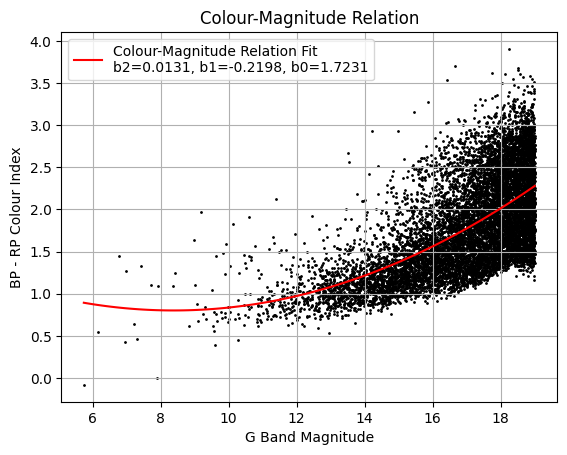

Colour-Magnitude Relation Coefficients:
b0:  1.7230807913118062
b1:  -0.21975938165075323
b2:  0.013105425489788105


In [111]:
#find a simple colour-magnitude relation from the data set
#M_G = G - 5 * log10(d / 10) - A_G + 5

coeffs = np.polyfit(magnitude, colour, deg=2)

b2, b1, b0 = coeffs

#plot the colour-magnitude relation
plt.figure()
plt.scatter(magnitude, colour, s=1, color='black')
#add the fitted curve
x_fit = np.linspace(min(magnitude), max(magnitude), 100)
y_fit = b0 + b1 * x_fit + b2 * x_fit**2
plt.plot(x_fit, y_fit, 'r-', label='Colour-Magnitude Relation Fit \nb2={:.4f}, b1={:.4f}, b0={:.4f}'.format(b2, b1, b0))
plt.xlabel('G Band Magnitude')
plt.ylabel('BP - RP Colour Index')
plt.title('Colour-Magnitude Relation')
plt.legend()
plt.grid(True)
plt.show()

print("Colour-Magnitude Relation Coefficients:")
print("b0: ", b0)
print("b1: ", b1)
print("b2: ", b2)



Parallax SNR =  0.39840712362027025
Naive Distance =  2353.079719434791  pc
Colour (BP-RP) =  1.2832355
G Band Magnitude =  18.536036
Extinction A_G =  0.0017
L scale length =  250  pc
Sample Star Parallax:  0.4249749771504553  mas
Sample Star distance GSP-Phot:  917.9784  pc


100%|██████████| 3000/3000 [00:16<00:00, 187.09it/s]


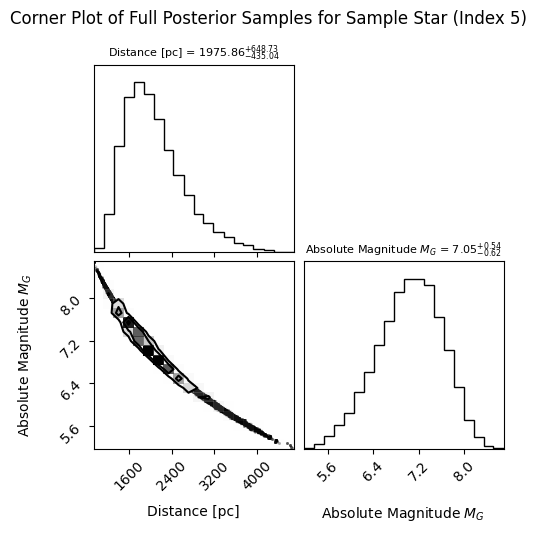

Median Distance from Full Posterior MCMC Samples:  1975.8601184981094  pc
Mode Distance from Full Posterior MCMC Samples:  1717.3730950945358  pc


In [188]:
#therefore we can define c(M_G) = b0 + b1 * M_G + b2 * M_G^2
def Colour_Magnitude_Relation(magnitude):
    return b0 + b1 * magnitude + b2 * magnitude**2

M_0 = 8.5 #magnitude normalization, reflects most faint gaia stars being dwarfs
sigma_C = 0.1 #colour scatter
sigma_A = 0.1 #extinction scatter
sigma_G = 0.02 #photometric scatter
sigma_M = 1.0 #absolute magnitude scatter

#sanity check on values
print(r'Parallax SNR = ', σ_p[sample_index]/ p[sample_index])
print(r'Naive Distance = ', 1000 / p[sample_index], ' pc')
print(r'Colour (BP-RP) = ', colour[sample_index])
print(r'G Band Magnitude = ', magnitude[sample_index])
print(r'Extinction A_G = ', extinction[sample_index])   
print(r'L scale length = ', L_lb(l[sample_index], b[sample_index]), ' pc')


def fullPosterior(theta, p, σ_p, magnitude, colour, extinction, L=L_star, p_zeropoint=-0.029):
    d, M_G = theta
    
    if d <= 0:
        return -np.inf  # log(0) for non-physical distances
    #parallax likelihood
    likelihood_parallax = -0.5 * ((p - p_zeropoint - 1000 / d) / σ_p)**2 - np.log(np.sqrt(2 * np.pi) * σ_p)
    #extinction 
    prior_extinction = -0.5 * ((extinction - Extinction_Prior(d, a0, h)) / sigma_A)**2 - np.log(np.sqrt(2 * np.pi) * sigma_A)
    #photometry
    magnitude_model = M_G + 5 * np.log10(d) + extinction - 5
    photometric_likelihood = -0.5 * ((magnitude - magnitude_model) / sigma_G)**2 - np.log(np.sqrt(2 * np.pi) * sigma_G)
    #colour
    colour_model = Colour_Magnitude_Relation(M_G)
    prior_colour_magnitude = -0.5 * ((colour - colour_model) / sigma_C)**2 - np.log(np.sqrt(2 * np.pi) * sigma_C)
    #absolute mag prior
    #if M_G < 4.5: #or M_G > 12:
    #    return -np.inf  # log(0) for non-physical absolute magnitudes
    
    #prior_absolute_magnitude = -0.5 * ((M_G - M_0) / sigma_M)**2 - np.log(np.sqrt(2 * np.pi) * sigma_M) 
    #distance prior
    prior_distance = 2 * np.log(d) - d / L - 3 * np.log(L) + np.log(0.5)  #log of (1/2L^3) * d^2 * exp(-d/L)
    
    return likelihood_parallax + prior_distance + photometric_likelihood + prior_colour_magnitude + prior_extinction #+ prior_absolute_magnitude

#now do an MCMC sampling of the full posterior for a sample star

def log_fullPosterior(theta, p, σ_p, magnitude, colour, extinction, L=L_star, p_zeropoint=-0.029):
    return fullPosterior(theta, p, σ_p, magnitude, colour, extinction, L, p_zeropoint)

print(r"Sample Star Parallax: ", p[sample_index], " mas")
print(r"Sample Star distance GSP-Phot: ", distance[sample_index], " pc")
#set up the MCMC sampler
ndim = 2  # number of parameters (distance, absolute magnitude)
nwalkers = 100  # number of walkers
initial_pos = np.array([distance[sample_index], 5.0]) + 10 * np.random.randn(nwalkers, ndim)  # initial positions
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_fullPosterior, args=(p[sample_index], σ_p[sample_index], magnitude[sample_index], colour[sample_index], extinction[sample_index], L_lb(l[sample_index], b[sample_index]), -0.029))
#run the MCMC sampler
nsteps = 3000
sampler.run_mcmc(initial_pos, nsteps, progress=True)
#analyze the MCMC samples
samples = sampler.get_chain(discard=1000, flat=True)  # discard burn-in samples
#plot the posterior samples using corner plot
fig = corner.corner(
    samples,
    labels=[r'Distance [pc]', r'Absolute Magnitude $M_G$'],
    truths=[distance[sample_index], None],
    show_titles=True,
    title_fmt='.2f',
    label_kwargs={"fontsize": 10},
    title_kwargs={"fontsize": 8}
)   
plt.suptitle(r'Corner Plot of Full Posterior Samples for Sample Star (Index {})'.format(sample_index), fontsize=12)
plt.subplots_adjust(top=0.88)
plt.show()

#print the median and mode distance from the samples
distance_samples = samples[:, 0]
median_distance_full = np.median(distance_samples)  
kde = stats.gaussian_kde(distance_samples)
d_grid = np.linspace(distance_samples.min(), distance_samples.max(), 2000)
pdf = kde(d_grid)
mode_distance_full = d_grid[np.argmax(pdf)]
print(r'Median Distance from Full Posterior MCMC Samples: ', median_distance_full, ' pc')
print(r'Mode Distance from Full Posterior MCMC Samples: ', mode_distance_full, ' pc')



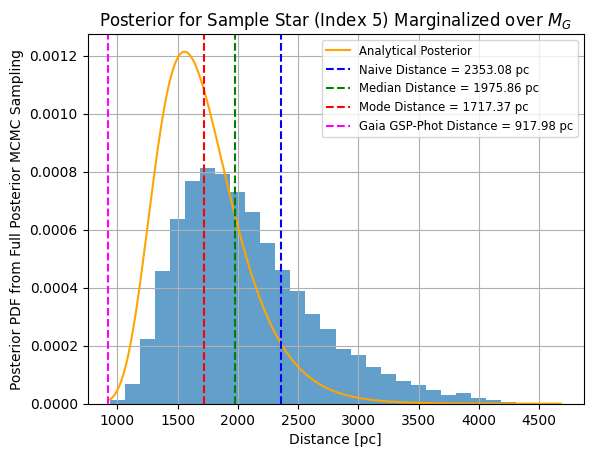

In [189]:
#marginalise over absolute magnitude to get distance posterior
distance_samples = samples[:, 0]
#plot the posterior histogram
plt.figure()
plt.hist(distance_samples, bins=30, density=True, alpha=0.7)
#plot also the initial analytical posterior for comparison between the relevant distance range given by distance_samples
d_range = np.linspace(np.min(distance_samples), np.max(distance_samples), 1000)  # distance range from min to max of samples

posterior = Posterior(d_range, p[sample_index], σ_p[sample_index], L=L_lb(l[sample_index], b[sample_index]), p_zeropoint=-0.029)
#normalize the posterior for plotting
posterior /= np.trapezoid(posterior, d_range)
plt.plot(d_range, 
        posterior,
        label='Analytical Posterior',
        color='orange'
)

plt.xlabel('Distance [pc]')
plt.ylabel('Posterior PDF from Full Posterior MCMC Sampling')
plt.title(r'Posterior for Sample Star (Index {}) Marginalized over $M_G$'.format(sample_index))
#mark naive distance, median and mode
plt.axvline(1000 / p[sample_index], color='blue', linestyle='--', label='Naive Distance = {:.2f} pc'.format(1000 / p[sample_index]))
plt.axvline(median_distance_full, color='green', linestyle='--', label='Median Distance = {:.2f} pc'.format(median_distance_full))
plt.axvline(mode_distance_full, color='red', linestyle='--', label='Mode Distance = {:.2f} pc'.format(mode_distance_full))
plt.axvline(distance[sample_index], color='magenta', linestyle='--', label='Gaia GSP-Phot Distance = {:.2f} pc'.format(distance[sample_index]))
plt.grid(True)
plt.legend(fontsize='small')
plt.show()


In [114]:
#for a sample of 1000 stars from the dataset, perform the full posterior MCMC sampling and save the median, mode distances, 68%, 95% credible intervals
num_samples = 1
indices = np.random.choice(len(p), num_samples, replace=False)
modes_fullposterior = []
medians_fullposterior = []
credible_intervals_68 = []
credible_intervals_95 = []

for i in indices:
    L_star = L_lb(l[i], b[i])
    
    #set up the MCMC sampler
    ndim = 2  # number of parameters (distance, absolute magnitude)
    nwalkers = 100  # number of walkers
    initial_pos = np.array([distance[i], 5.0]) + 10 * np.random.randn(nwalkers, ndim)  # initial positions
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_fullPosterior, args=(p[i], σ_p[i], magnitude[i], colour[i], extinction[i], L_star, -0.029))
    #run the MCMC sampler
    nsteps = 3000
    sampler.run_mcmc(initial_pos, nsteps, progress=False)
    #analyze the MCMC samples
    samples = sampler.get_chain(discard=1000, flat=True)  # discard burn-in samples
    distance_samples = samples[:, 0]
    
    #median
    median_distance_full = np.median(distance_samples)  
    medians_fullposterior.append(median_distance_full)
    
    #mode
    kde = stats.gaussian_kde(distance_samples)
    d_grid = np.linspace(distance_samples.min(), distance_samples.max(), 2000)
    pdf = kde(d_grid)
    mode_distance_full = d_grid[np.argmax(pdf)]
    modes_fullposterior.append(mode_distance_full)
    
    #credible intervals
    lower_68 = np.percentile(distance_samples, 16)
    upper_68 = np.percentile(distance_samples, 84)
    credible_intervals_68.append((lower_68, upper_68))
    
    lower_95 = np.percentile(distance_samples, 2.5)
    upper_95 = np.percentile(distance_samples, 97.5)
    credible_intervals_95.append((lower_95, upper_95))
    #update this print statement to show progress
    if (i - indices[0]) % 100 == 0:
        print(f'Processed {i - indices[0]} / {num_samples} stars', end='\r')
    print()
    
    
    

    

Processed 0 / 1 stars


In [91]:
from scipy.special import logsumexp
from scipy.optimize import minimize_scalar
from joblib import Parallel, delayed
from tqdm import tqdm


#now iterate over 10000 stars in the dataset and calculate the new posterior without MCMC, just analytically
modes_fullposterior_analytic = []
medians_fullposterior_analytic = []
p_zeropoint = -0.029
d0 = 1000/ max(p[i] - p_zeropoint, 0.1)  #initial distance guess based on parallax
d_grid = np.linspace(0.2*d0, 5*d0, 500)  # distance range centred on parallax distance estimate

def profile_log_posterior_d (d, p, σ_p, magnitude, colour, extinction, L=L_star, p_zeropoint=-0.029):
    if d <= 0:
        return -np.inf  # log(0) for non-physical distances
    
    def neg_logp_M_G(M_G):
        theta = (d, M_G)
        return -fullPosterior(theta, p, σ_p, magnitude, colour, extinction, L, p_zeropoint)
    
    res = minimize_scalar(neg_logp_M_G, bounds=(-5, 15), method='bounded')
    return -res.fun

#evaluate on a distance grid to find median and mode
#calculate for all stars

N=len(p)

def process_one_star(i):
    
    L_star = L_lb(l[i], b[i])
    
    #per-star distance grid
    d0 = 1000/ max(p[i] - p_zeropoint, 0.1)  #initial distance guess based on parallax
    d_grid = np.linspace(0.2*d0, 5*d0, 500)  # distance range centred on parallax distance estimate
    
    logp_d = np.array([profile_log_posterior_d(d, p[i], σ_p[i], magnitude[i], colour[i], extinction[i], L_star, -0.029) for d in d_grid])
    logp_d -= logsumexp(logp_d)  #normalize in log space
    p_d = np.exp(logp_d)
    #cdf
    cdf = np.cumsum(p_d)
    cdf /= cdf[-1]
    #mode
    mode_distance = d_grid[np.argmax(p_d)]
    #median
    median_distance = np.interp(0.5, cdf, d_grid)
    
    return median_distance, mode_distance

    #update this print statement to show progress

results = Parallel(n_jobs=-1, backend='loky')(
    delayed(process_one_star)(i) for i in tqdm(range(N))

)

#save results to the table
medians_fullposterior_analytic = np.array([r[0] for r in results])
modes_fullposterior_analytic   = np.array([r[1] for r in results])
#indices_processed = np.array([r[2] for r in results])

table['median_fullposterior_analytic'] = medians_fullposterior_analytic
table['mode_fullposterior_analytic'] = modes_fullposterior_analytic



#get rid of outliers where distance estimate is > 2000pc
#outlier_mask = (medians_fullposterior_analytic < 2000) & (modes_fullposterior_analytic < 2000)
#table = table[outlier_mask]
#medians_fullposterior_analytic = medians_fullposterior_analytic[outlier_mask]
#modes_fullposterior_analytic = modes_fullposterior_analytic[outlier_mask]

print(len(table), len(medians_fullposterior_analytic), len(modes_fullposterior_analytic))





100%|██████████| 10000/10000 [07:10<00:00, 23.21it/s]


ValueError: could not broadcast input array from shape (10000,) into shape (7651,)

In [115]:
#print the first ten entries of the new distance estimates
print("First 10 Median Distances from Full Posterior Analytic:")
print(medians_fullposterior_analytic[:10])
print("First 10 Mode Distances from Full Posterior Analytic:")
print(modes_fullposterior_analytic[:10])
print(len(table))
print(len(distance))
print(len(medians_fullposterior_analytic))


First 10 Median Distances from Full Posterior Analytic:
[ 672.35446012 4066.38112778  427.43748873  659.81870906  640.21488445
 1949.48488427  809.00800952 4007.36945356 4621.3314009  6261.78952887]
First 10 Mode Distances from Full Posterior Analytic:
[ 674.65413444 5086.67224675  420.6930214   632.17003276  641.69060297
 1775.45473785  811.57001049 1058.35447132  828.82737852 6209.45343855]
10000
10000
10000


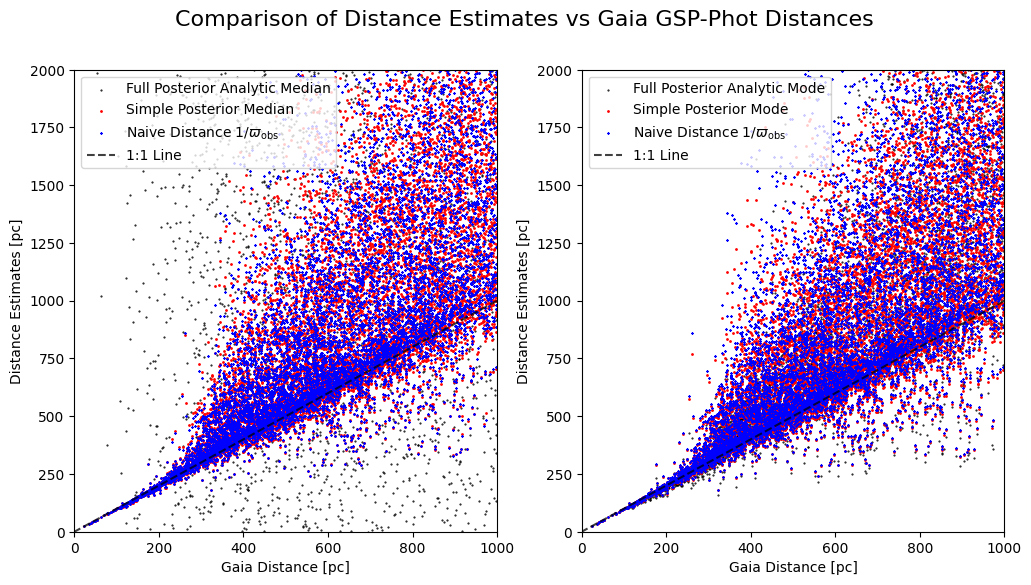

In [83]:

#on the same plots, show the naive distance estimates for comparison as well as the mode/median from the first posterior
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#set manual axis limits to be the same for both subplots



ax = axes[0]  # first subplot
ax.scatter(
    distance,
    medians_fullposterior_analytic,
    color='black',
    s=1,
    marker='.',
    label=r'Full Posterior Analytic Median'
)
ax.scatter(
    distance,
    medians_posterior,  
    color='red',
    s=1,
    marker='o',
    label=r'Simple Posterior Median' 
)
ax.scatter(
    distance,
    distance_naive_all,
    color='blue',
    s=1,
    marker='x',
    label=r'Naive Distance $1/\varpi_{\mathrm{obs}}$'
)
#compute shared limits for 1:1 line
lims = [
    max(ax.get_xlim()[0], ax.get_ylim()[0]),
    min(ax.get_xlim()[1], ax.get_ylim()[1])
]   
ax.plot(
    lims,
    lims,
    'k--',
    alpha=0.75,
    zorder=2,
    label=r'1:1 Line'
)
#set lower x and y limits to 0  
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
#set higher x and y limits to 2000
ax.set_xlim(xmax=1000)
ax.set_ylim(ymax=2000)
ax.set_xlabel(r'Gaia Distance [pc]')
ax.set_ylabel(r'Distance Estimates [pc]')
ax.legend()
ax = axes[1]  # second subplot
ax.scatter(
    distance,
    modes_fullposterior_analytic,
    color='black',
    s=1,
    marker='.',
    label=r'Full Posterior Analytic Mode'
)
ax.scatter(
    distance,
    modes_posterior,  
    color='red',
    s=1,
    marker='o',
    label=r'Simple Posterior Mode' 
)
ax.scatter(
    distance,
    distance_naive_all,
    color='blue',
    s=1,
    marker='x',
    label=r'Naive Distance $1/\varpi_{\mathrm{obs}}$'
)
#compute shared limits for 1:1 line
lims = [
    max(ax.get_xlim()[0], ax.get_ylim()[0]),
    min(ax.get_xlim()[1], ax.get_ylim()[1])
]   
ax.plot(
    lims,
    lims,
    'k--',
    alpha=0.75,
    zorder=2,
    label=r'1:1 Line'
)
#set lower x and y limits to 0  
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
#set higher x and y limits to 2000
ax.set_xlim(xmax=1000)
ax.set_ylim(ymax=2000)
ax.set_xlabel(r'Gaia Distance [pc]')
ax.set_ylabel(r'Distance Estimates [pc]')
ax.legend()
#set a joint title for the figure
plt.suptitle(r'Comparison of Distance Estimates vs Gaia GSP-Phot Distances', fontsize=16)
plt.show()
    

number of naive distances:  10000
number of simple posterior modes:  10000
number of full posterior analytic modes:  10000


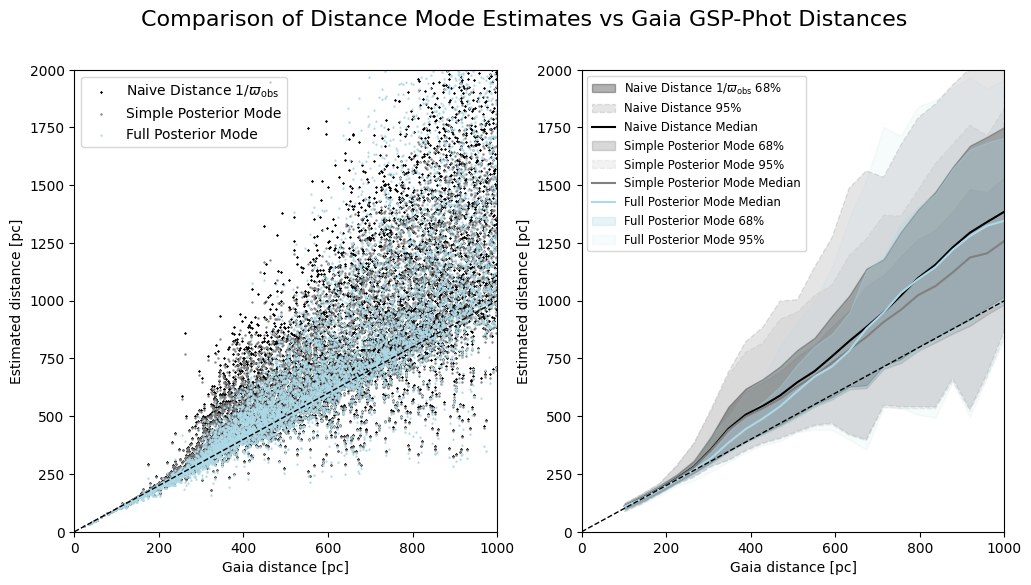

In [141]:
#plotting modes comparison in a single scatter plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]

distance = np.asarray(distance)
distance_naive_all = np.asarray(distance_naive_all)
modes_posterior = np.asarray(modes_posterior)
modes_fullposterior_analytic = np.asarray(modes_fullposterior_analytic)

global_mask = (
    np.isfinite(modes_fullposterior_analytic) &
    (modes_fullposterior_analytic <= 2000)
)

print("number of naive distances: ", np.sum(np.isfinite(distance_naive_all)))
print("number of simple posterior modes: ", np.sum(np.isfinite(modes_posterior)))
print("number of full posterior analytic modes: ", np.sum(np.isfinite(modes_fullposterior_analytic)))


ax.scatter(
    distance[global_mask],
    distance_naive_all[global_mask],
    color='black',
    s=0.5,
    marker='x',
    label=r'Naive Distance $1/\varpi_{\mathrm{obs}}$'
)
ax.scatter(
    distance[global_mask],
    modes_posterior[global_mask],
    color='grey',
    s=0.5,
    marker='o',
    label=r'Simple Posterior Mode'
)
ax.scatter(
    distance[global_mask],
    modes_fullposterior_analytic[global_mask],
    color='lightblue',
    s=0.5,
    marker='^',
    label=r'Full Posterior Mode'
)
#set lower x and y limits to 0  
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
#set higher x and y limits
ax.set_xlim(xmax=1000)
ax.set_ylim(ymax=2000)
#compute shared limits for 1:1 line
lims = [
    max(ax.get_xlim()[0], ax.get_ylim()[0]),
    min(ax.get_xlim()[1], ax.get_ylim()[1])
]
ax.plot(lims, lims, 'k--', lw=1)
#plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel(r"Gaia distance [pc]")
ax.set_ylabel(r"Estimated distance [pc]")
ax.legend()

ax = axes[1]
#plot the same as above but within an envelope instead of raw data points
x_bins = np.linspace(0, 2000, 50)
bin_centers = 0.5 * (x_bins[:-1] + x_bins[1:])
#calculate the 16th and 84th percentiles for each bin
naive_percentiles68 = []
simple_percentiles68 = []
full_percentiles68 = []
min_count = 20  #minimum number of points per bin to compute percentiles

for j in range(len(x_bins) - 1):
    bin_mask = (
    global_mask &
    (distance >= x_bins[j]) &
    (distance < x_bins[j + 1])
    )
    naive_bin_values = np.array(distance_naive_all)[bin_mask]
    simple_bin_values = np.array(modes_posterior)[bin_mask]
    full_bin_values = np.array(modes_fullposterior_analytic)[bin_mask]
    
    if len(naive_bin_values) > min_count:
        naive_percentiles68.append((
            np.percentile(naive_bin_values, 16),
            np.percentile(naive_bin_values, 84)
        ))
    else:
        naive_percentiles68.append((np.nan, np.nan))
        
    if len(simple_bin_values) > min_count:
        simple_percentiles68.append((
            np.percentile(simple_bin_values, 16),
            np.percentile(simple_bin_values, 84)
        ))
    else:
        simple_percentiles68.append((np.nan, np.nan))
        
    if len(full_bin_values) > min_count:
        full_percentiles68.append((
            np.percentile(full_bin_values, 16),
            np.percentile(full_bin_values, 84)
        ))
    else:
        full_percentiles68.append((np.nan, np.nan))
        
naive_percentiles68 = np.array(naive_percentiles68)
simple_percentiles68 = np.array(simple_percentiles68)
full_percentiles68 = np.array(full_percentiles68)

naive_percentiles95 = []
simple_percentiles95 = []
full_percentiles95 = []

for j in range(len(x_bins) - 1):
    bin_mask = (
    global_mask &
    (distance >= x_bins[j]) &
    (distance < x_bins[j + 1])
    )
    naive_bin_values = np.array(distance_naive_all)[bin_mask]
    simple_bin_values = np.array(modes_posterior)[bin_mask]
    full_bin_values = np.array(modes_fullposterior_analytic)[bin_mask]
    
    if len(naive_bin_values) > min_count:
        naive_percentiles95.append((
            np.percentile(naive_bin_values, 2.5),
            np.percentile(naive_bin_values, 97.5)
        ))
    else:
        naive_percentiles95.append((np.nan, np.nan))
        
    if len(simple_bin_values) > min_count:
        simple_percentiles95.append((
            np.percentile(simple_bin_values, 2.5),
            np.percentile(simple_bin_values, 97.5)
        ))
    else:
        simple_percentiles95.append((np.nan, np.nan))
        
    if len(full_bin_values) > min_count:
        full_percentiles95.append((
            np.percentile(full_bin_values, 2.5),
            np.percentile(full_bin_values, 97.5)
        ))
    else:
        full_percentiles95.append((np.nan, np.nan))
        
naive_percentiles95 = np.array(naive_percentiles95)
simple_percentiles95 = np.array(simple_percentiles95)
full_percentiles95 = np.array(full_percentiles95)
#plot the envelopes

valid = np.isfinite(full_percentiles95[:, 0])
ax.fill_between(
    bin_centers,
    naive_percentiles68[:, 0],
    naive_percentiles68[:, 1],
    color='black',
    alpha=0.3,
    label=r'Naive Distance $1/\varpi_{\mathrm{obs}}$ 68%'
)
ax.fill_between(
    bin_centers,
    naive_percentiles95[:, 0],
    naive_percentiles95[:, 1],
    color='black',
    linestyle='--',
    alpha=0.1,
    label=r'Naive Distance 95%'
)

ax.plot(
    bin_centers,
    (naive_percentiles68[:, 0] + naive_percentiles68[:, 1]) / 2,
    color='black',
    linestyle='-',
    label=r'Naive Distance Median'
)
ax.fill_between(
    bin_centers,
    simple_percentiles68[:, 0],
    simple_percentiles68[:, 1],
    color='grey',
    alpha=0.3,
    label=r'Simple Posterior Mode 68%'
)
ax.fill_between(
    bin_centers,
    simple_percentiles95[:, 0],
    simple_percentiles95[:, 1],
    color='grey',
    linestyle='--',
    alpha=0.1,
    label=r'Simple Posterior Mode 95%'
)
ax.plot(
    bin_centers,
    (simple_percentiles68[:, 0] + simple_percentiles68[:, 1]) / 2,
    color='grey',
    linestyle='-',
    label=r'Simple Posterior Mode Median'
)
ax.plot(
    bin_centers[valid],
    (full_percentiles68[valid, 0] + full_percentiles68[valid, 1]) / 2,
    color='lightblue',
    linestyle='-',
    label=r'Full Posterior Mode Median'
)
ax.fill_between(
    bin_centers[valid],
    full_percentiles68[valid, 0],
    full_percentiles68[valid, 1],
    color='lightblue',
    alpha=0.3,
    label=r'Full Posterior Mode 68%'
)
ax.fill_between(
    bin_centers[valid],
    full_percentiles95[valid, 0],
    full_percentiles95[valid, 1],
    color='lightblue',
    alpha=0.1,
    label=r'Full Posterior Mode 95%'
)
#also add median lines and 95% intervals with dashed lines


#set lower x and y limits to 0
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
#set higher x and y limits
ax.set_xlim(xmax=1000)
ax.set_ylim(ymax=2000)
#compute shared limits for 1:1 line
lims = [
    max(ax.get_xlim()[0], ax.get_ylim()[0]),
    min(ax.get_xlim()[1], ax.get_ylim()[1])
]
ax.plot(lims, lims, 'k--', lw=1)
#plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel(r"Gaia distance [pc]")
ax.set_ylabel(r"Estimated distance [pc]")
ax.legend(fontsize='small')
plt.suptitle(r'Comparison of Distance Mode Estimates vs Gaia GSP-Phot Distances', fontsize=16)
plt.show()



number of naive distances:  10000
number of simple posterior medians:  10000
number of full posterior analytic medians:  10000


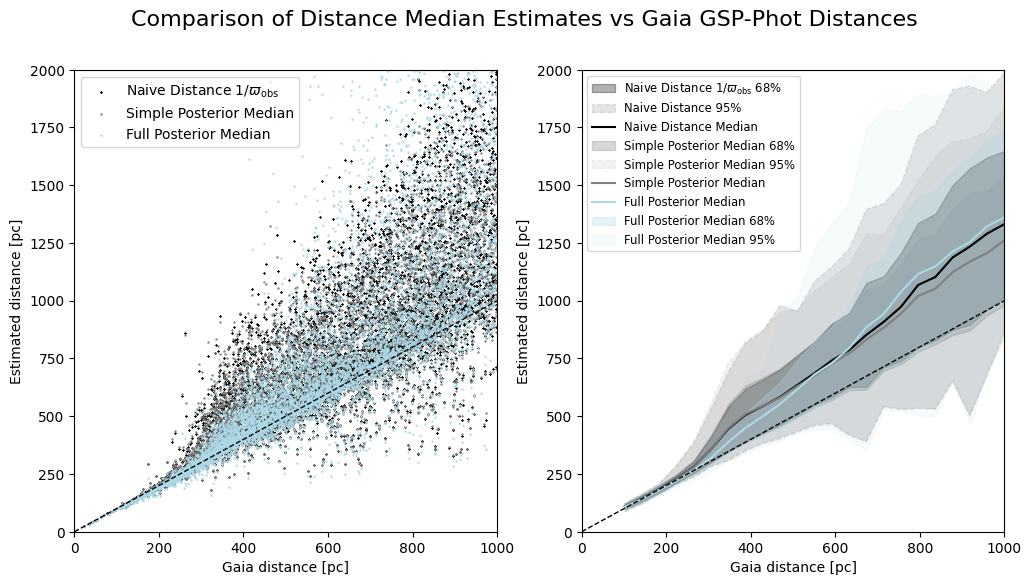

In [142]:
#plotting medians comparison in a single scatter plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]

distance = np.asarray(distance)
distance_naive_all = np.asarray(distance_naive_all)
medians_posterior = np.asarray(medians_posterior)
medians_fullposterior_analytic = np.asarray(medians_fullposterior_analytic)

global_mask = (
    np.isfinite(medians_fullposterior_analytic) &
    (medians_fullposterior_analytic <= 2000)
)

print("number of naive distances: ", np.sum(np.isfinite(distance_naive_all)))
print("number of simple posterior medians: ", np.sum(np.isfinite(medians_posterior)))
print("number of full posterior analytic medians: ", np.sum(np.isfinite(medians_fullposterior_analytic)))


ax.scatter(
    distance[global_mask],
    distance_naive_all[global_mask],
    color='black',
    s=0.5,
    marker='x',
    label=r'Naive Distance $1/\varpi_{\mathrm{obs}}$'
)
ax.scatter(
    distance[global_mask],
    medians_posterior[global_mask],
    color='grey',
    s=0.5,
    marker='o',
    label=r'Simple Posterior Median'
)
ax.scatter(
    distance[global_mask],
    medians_fullposterior_analytic[global_mask],
    color='lightblue',
    s=0.5,
    marker='^',
    label=r'Full Posterior Median'
)
#set lower x and y limits to 0  
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
#set higher x and y limits
ax.set_xlim(xmax=1000)
ax.set_ylim(ymax=2000)
#compute shared limits for 1:1 line
lims = [
    max(ax.get_xlim()[0], ax.get_ylim()[0]),
    min(ax.get_xlim()[1], ax.get_ylim()[1])
]
ax.plot(lims, lims, 'k--', lw=1)
#plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel(r"Gaia distance [pc]")
ax.set_ylabel(r"Estimated distance [pc]")
ax.legend()

ax = axes[1]
#plot the same as above but within an envelope instead of raw data points
x_bins = np.linspace(0, 2000, 50)
bin_centers = 0.5 * (x_bins[:-1] + x_bins[1:])
#calculate the 16th and 84th percentiles for each bin
naive_percentiles68 = []
simple_percentiles68 = []
full_percentiles68 = []
min_count = 20  #minimum number of points per bin to compute percentiles

for j in range(len(x_bins) - 1):
    bin_mask = (
    global_mask &
    (distance >= x_bins[j]) &
    (distance < x_bins[j + 1])
    )
    naive_bin_values = np.array(distance_naive_all)[bin_mask]
    simple_bin_values = np.array(medians_posterior)[bin_mask]
    full_bin_values = np.array(medians_fullposterior_analytic)[bin_mask]
    
    if len(naive_bin_values) > min_count:
        naive_percentiles68.append((
            np.percentile(naive_bin_values, 16),
            np.percentile(naive_bin_values, 84)
        ))
    else:
        naive_percentiles68.append((np.nan, np.nan))
        
    if len(simple_bin_values) > min_count:
        simple_percentiles68.append((
            np.percentile(simple_bin_values, 16),
            np.percentile(simple_bin_values, 84)
        ))
    else:
        simple_percentiles68.append((np.nan, np.nan))
        
    if len(full_bin_values) > min_count:
        full_percentiles68.append((
            np.percentile(full_bin_values, 16),
            np.percentile(full_bin_values, 84)
        ))
    else:
        full_percentiles68.append((np.nan, np.nan))
        
naive_percentiles68 = np.array(naive_percentiles68)
simple_percentiles68 = np.array(simple_percentiles68)
full_percentiles68 = np.array(full_percentiles68)

naive_percentiles95 = []
simple_percentiles95 = []
full_percentiles95 = []

for j in range(len(x_bins) - 1):
    bin_mask = (
    global_mask &
    (distance >= x_bins[j]) &
    (distance < x_bins[j + 1])
    )
    naive_bin_values = np.array(distance_naive_all)[bin_mask]
    simple_bin_values = np.array(medians_posterior)[bin_mask]
    full_bin_values = np.array(medians_fullposterior_analytic)[bin_mask]
    
    if len(naive_bin_values) > min_count:
        naive_percentiles95.append((
            np.percentile(naive_bin_values, 2.5),
            np.percentile(naive_bin_values, 97.5)
        ))
    else:
        naive_percentiles95.append((np.nan, np.nan))
        
    if len(simple_bin_values) > min_count:
        simple_percentiles95.append((
            np.percentile(simple_bin_values, 2.5),
            np.percentile(simple_bin_values, 97.5)
        ))
    else:
        simple_percentiles95.append((np.nan, np.nan))
        
    if len(full_bin_values) > min_count:
        full_percentiles95.append((
            np.percentile(full_bin_values, 2.5),
            np.percentile(full_bin_values, 97.5)
        ))
    else:
        full_percentiles95.append((np.nan, np.nan))
        
naive_percentiles95 = np.array(naive_percentiles95)
simple_percentiles95 = np.array(simple_percentiles95)
full_percentiles95 = np.array(full_percentiles95)
#plot the envelopes

valid = np.isfinite(full_percentiles95[:, 0])
ax.fill_between(
    bin_centers,
    naive_percentiles68[:, 0],
    naive_percentiles68[:, 1],
    color='black',
    alpha=0.3,
    label=r'Naive Distance $1/\varpi_{\mathrm{obs}}$ 68%'
)
ax.fill_between(
    bin_centers,
    naive_percentiles95[:, 0],
    naive_percentiles95[:, 1],
    color='black',
    linestyle='--',
    alpha=0.1,
    label=r'Naive Distance 95%'
)

ax.plot(
    bin_centers,
    (naive_percentiles68[:, 0] + naive_percentiles68[:, 1]) / 2,
    color='black',
    linestyle='-',
    label=r'Naive Distance Median'
)
ax.fill_between(
    bin_centers,
    simple_percentiles68[:, 0],
    simple_percentiles68[:, 1],
    color='grey',
    alpha=0.3,
    label=r'Simple Posterior Median 68%'
)
ax.fill_between(
    bin_centers,
    simple_percentiles95[:, 0],
    simple_percentiles95[:, 1],
    color='grey',
    linestyle='--',
    alpha=0.1,
    label=r'Simple Posterior Median 95%'
)
ax.plot(
    bin_centers,
    (simple_percentiles68[:, 0] + simple_percentiles68[:, 1]) / 2,
    color='grey',
    linestyle='-',
    label=r'Simple Posterior Median'
)
ax.plot(
    bin_centers[valid],
    (full_percentiles68[valid, 0] + full_percentiles68[valid, 1]) / 2,
    color='lightblue',
    linestyle='-',
    label=r'Full Posterior Median'
)
ax.fill_between(
    bin_centers[valid],
    full_percentiles68[valid, 0],
    full_percentiles68[valid, 1],
    color='lightblue',
    alpha=0.3,
    label=r'Full Posterior Median 68%'
)
ax.fill_between(
    bin_centers[valid],
    full_percentiles95[valid, 0],
    full_percentiles95[valid, 1],
    color='lightblue',
    alpha=0.1,
    label=r'Full Posterior Median 95%'
)
#also add median lines and 95% intervals with dashed lines


#set lower x and y limits to 0
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
#set higher x and y limits
ax.set_xlim(xmax=1000)
ax.set_ylim(ymax=2000)
#compute shared limits for 1:1 line
lims = [
    max(ax.get_xlim()[0], ax.get_ylim()[0]),
    min(ax.get_xlim()[1], ax.get_ylim()[1])
]
ax.plot(lims, lims, 'k--', lw=1)
#plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel(r"Gaia distance [pc]")
ax.set_ylabel(r"Estimated distance [pc]")
ax.legend(fontsize='small')
plt.suptitle(r'Comparison of Distance Median Estimates vs Gaia GSP-Phot Distances', fontsize=16)
plt.show()



Full posterior length:  10000
Distance length:  10000


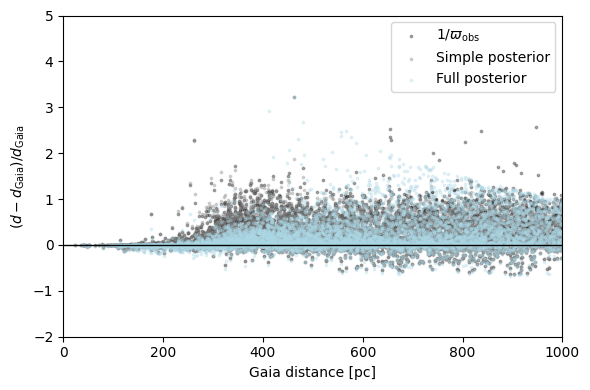

In [124]:
#plot the fractional residuals vs gaia distance, shows bias as function of distance

def frac_residual(d_est, d_ref):
    return (d_est - d_ref) / d_ref

plt.figure(figsize=(6, 4))
plt.scatter(distance[global_mask], frac_residual(distance_naive_all[global_mask], distance[global_mask]), s=3, alpha=0.3, color='black', label=r"$1/\varpi_{\mathrm{obs}}$")
plt.scatter(distance[global_mask], frac_residual(medians_posterior[global_mask], distance[global_mask]), s=3, alpha=0.3, color='grey', label=r"Simple posterior")
print('Full posterior length: ', len(medians_fullposterior_analytic))
print('Distance length: ', len(distance))
plt.scatter(distance[global_mask], frac_residual(medians_fullposterior_analytic[global_mask], distance[global_mask]), s=3, alpha=0.3, color='lightblue', label=r"Full posterior")
plt.axhline(0, color='k', lw=1)
plt.xlim(xmin=0, xmax=1000)
plt.ylim(-2, 5)

#plt.xscale('log')
plt.xlabel(r"Gaia distance [pc]")
plt.ylabel(r"$(d − d_{\mathrm{Gaia}}) / d_{\mathrm{Gaia}}$")
plt.legend()
plt.tight_layout()

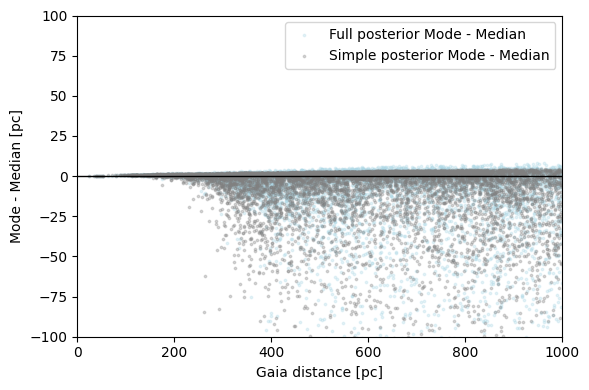

In [ ]:
#plot the mode - median difference as a function of distance too
plt.figure(figsize=(6, 4))
plt.scatter(distance[global_mask], (modes_fullposterior_analytic[global_mask] - medians_fullposterior_analytic[global_mask]), s=3, alpha=0.3, color='lightblue', label=r"Full posterior (Mode - Median)")
plt.scatter(distance[global_mask], (modes_posterior[global_mask] - medians_posterior[global_mask]), s=3, alpha=0.3, color='grey', label=r"Simple posterior (Mode - Median)")
plt.axhline(0, color='k', lw=1)
plt.xlim(xmin=0, xmax=1000)
plt.ylim(-100, 100)
#plt.xscale('log')
plt.xlabel(r"Gaia distance [pc]")
plt.ylabel(r"Mode - Median [pc]")
plt.legend()
plt.tight_layout()


In [143]:
from scipy.stats import spearmanr

#calculate spearman correlation coefficient for all three methods one by one
rho, pval = spearmanr(distance, distance_naive_all)    
print(r"Spearman correlation for Naive Distance: ", rho, pval)
rho, pval = spearmanr(distance, medians_posterior)
print(r"Spearman correlation for Simple Posterior: ", rho, pval)
rho, pval = spearmanr(distance[global_mask], medians_fullposterior_analytic[global_mask])
print(r"Spearman correlation for Full Posterior: ", rho, pval)


Spearman correlation for Naive Distance:  0.777735599073687 0.0
Spearman correlation for Simple Posterior:  0.8039950879957786 0.0
Spearman correlation for Full Posterior:  0.8898669074808748 0.0


In [145]:
#calculate median absolute fractional deviation for all three methods

def mad_frac(d_est, d_ref):
    return np.median(np.abs((d_est - d_ref) / d_ref))

mad_frac_naive = mad_frac(distance_naive_all, distance)
print(r"Median Absolute Fractional Deviation for Naive Distance: ", mad_frac_naive)
mad_frac_simple = mad_frac(medians_posterior, distance)
print(r"Median Absolute Fractional Deviation for Simple Posterior: ", mad_frac_simple)
mad_frac_full = mad_frac(medians_fullposterior_analytic[global_mask], distance[global_mask])
print(r"Median Absolute Fractional Deviation for Full Posterior: ", mad_frac_full)

Median Absolute Fractional Deviation for Naive Distance:  0.26585038835676333
Median Absolute Fractional Deviation for Simple Posterior:  0.24878579554049912
Median Absolute Fractional Deviation for Full Posterior:  0.11314753774657407


In [147]:
#calculate log-distance scatter

def log_scatter(d_est, d_ref):
    
    return np.std(np.log10(d_est / d_ref))

posmask = (distance > 0 ) & (distance_naive_all > 0) & np.isfinite(distance) & np.isfinite(distance_naive_all)
logratio = np.log10(distance_naive_all[posmask] / distance[posmask])
std_log_ratio = np.std(logratio)

log_scatter_naive = log_scatter(distance_naive_all[posmask], distance[posmask])
print(r"Log-Distance Scatter for Naive Distance: ", log_scatter_naive)
log_scatter_simple = log_scatter(medians_posterior, distance)
print(r"Log-Distance Scatter for Simple Posterior: ", log_scatter_simple)
log_scatter_full = log_scatter(medians_fullposterior_analytic[global_mask], distance[global_mask])
print(r"Log-Distance Scatter for Full Posterior: ", log_scatter_full)



Log-Distance Scatter for Naive Distance:  0.22230019265472886
Log-Distance Scatter for Simple Posterior:  0.15271094467442722
Log-Distance Scatter for Full Posterior:  0.11407081305291028


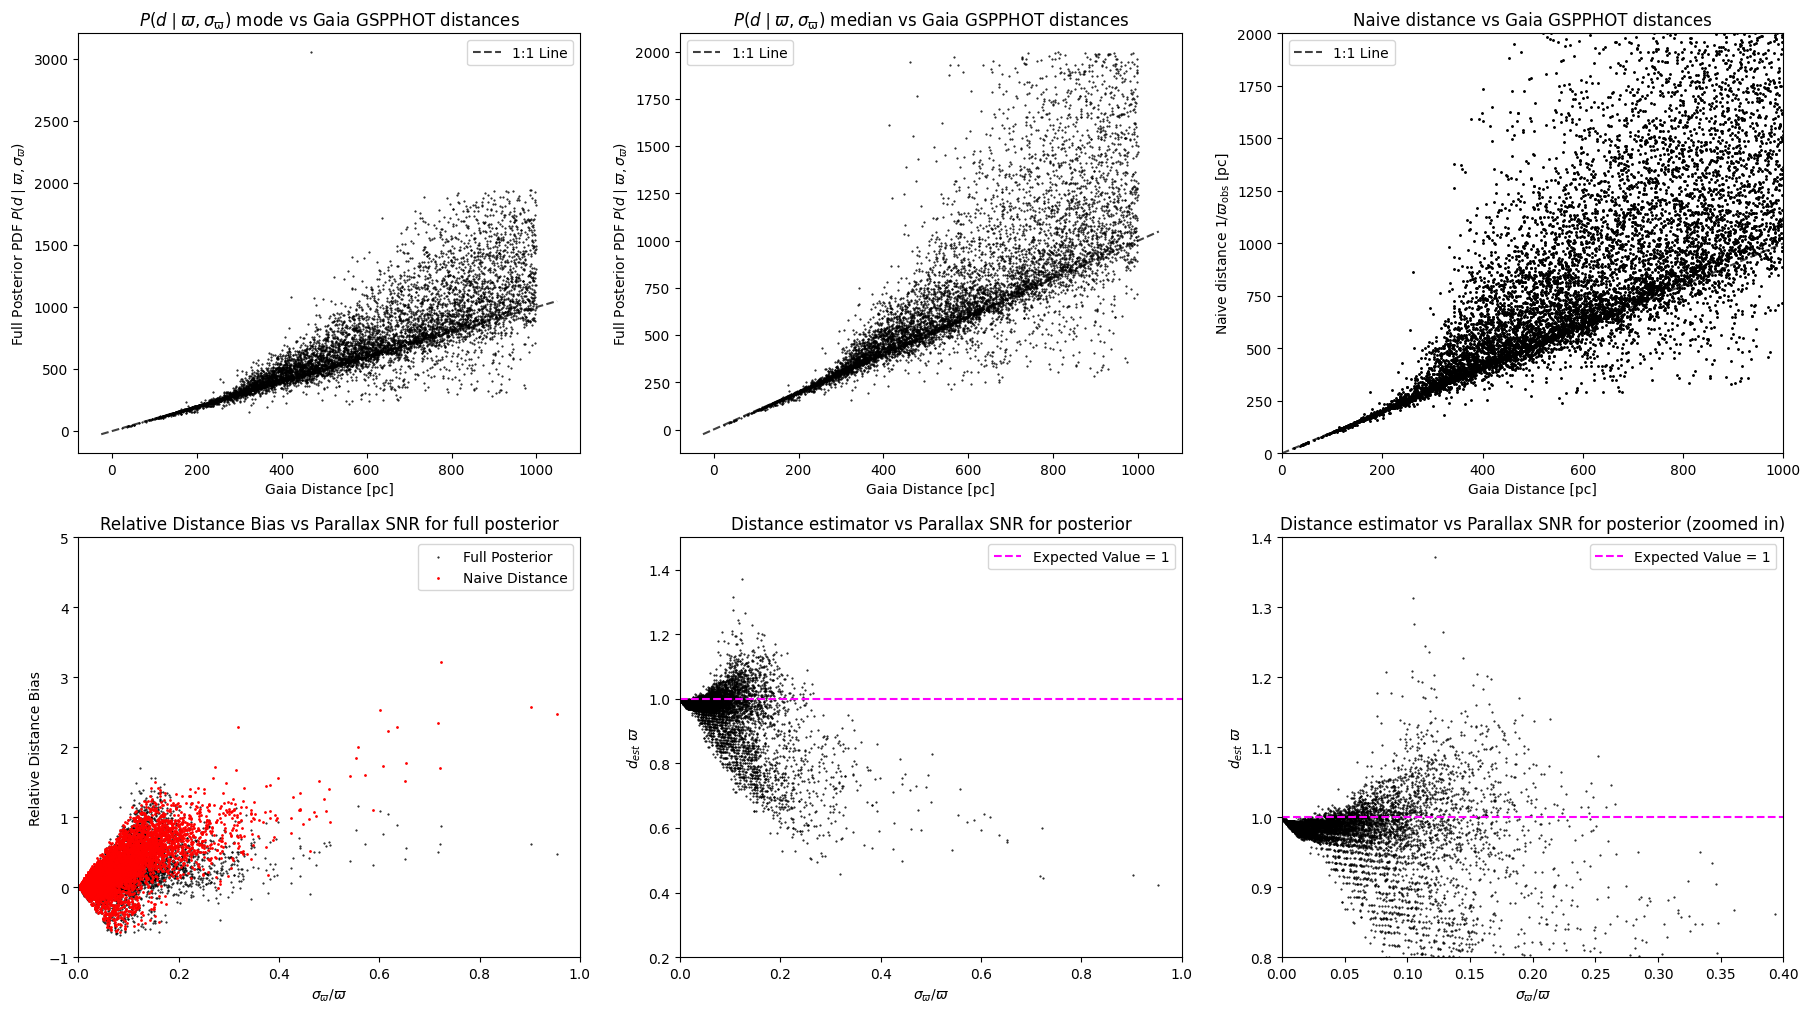

In [165]:
#various plots to compare posterior formulations
#posterior 2 for all 10000 stars 
#plot subplots in one figure

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
ax = axes[0, 0]  # first subplot
ax.scatter(
    distance[global_mask],
    modes_fullposterior_analytic[global_mask],
    color='black',
    s=1,
    marker='.'
)

#compute shared limits for 1:1 line
lims = [
    max(ax.get_xlim()[0], ax.get_ylim()[0]),
    min(ax.get_xlim()[1], ax.get_ylim()[1])
]

ax.plot(
    lims,
    lims,
    'k--',
    alpha=0.75,
    zorder=2,
    label='1:1 Line'
)

ax.set_xlabel(r'Gaia Distance [pc]')
ax.set_ylabel(r'Full Posterior PDF $P(d \mid \varpi, \sigma_{\varpi})$')
ax.set_title(r'$P(d \mid \varpi, \sigma_{\mathrm{\varpi}})$ mode vs Gaia GSPPHOT distances')
ax.legend()

ax = axes[0, 1]  # second subplot
ax.scatter(
    distance[global_mask],
    medians_fullposterior_analytic[global_mask],
    color='black',
    s=1,
    marker='.'
)

#compute shared limits for 1:1 line
lims = [
    max(ax.get_xlim()[0], ax.get_ylim()[0]),
    min(ax.get_xlim()[1], ax.get_ylim()[1])
]

ax.plot(
    lims,
    lims,
    'k--',
    alpha=0.75,
    zorder=2,
    label='1:1 Line'
)

ax.set_xlabel(r'Gaia Distance [pc]')
ax.set_ylabel(r'Full Posterior PDF $P(d \mid \varpi, \sigma_{\varpi})$')
ax.set_title(r'$P(d \mid \varpi, \sigma_{\mathrm{\varpi}})$ median vs Gaia GSPPHOT distances')
ax.legend()

ax = axes[0, 2]  # third subplot
ax.scatter(
    distance,
    distance_naive_all,
    color='black',
    s=1,
    marker='.'
)

#compute shared limits for 1:1 line
x_max = 1000
y_max = 2000
y_min = -2000
ax.scatter(distance, distance_naive_all, s=1, color='black')

ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)

line_max = min(x_max, y_max)
ax.plot([0, line_max], 
        [0, line_max],
        'k--', 
        alpha=0.75,
        zorder=2,
        label='1:1 Line')

ax.set_xlabel(r'Gaia Distance [pc]')
ax.set_ylabel(r'Naive distance $1/\varpi_{\mathrm{obs}}$ [pc]')
ax.set_title(r'Naive distance vs Gaia GSPPHOT distances')
ax.legend()

#ax = axes[1, 0]  # first subplot
#ax.scatter(
#    modes_posterior1,
#    modes_posterior2,
#    color='black',
#    s=1,
#    marker='.'
#)

#compute shared limits for 1:1 line
#lims = [
#    max(ax.get_xlim()[0], ax.get_ylim()[0]),
#    min(ax.get_xlim()[1], ax.get_ylim()[1])
#]

#ax.plot(
#    lims,
#    lims,
#    'k--',
#    alpha=0.75,
#    zorder=2,
#    label='1:1 Line'
#)

#ax.set_xlabel(r'Posterior PDF $P_1(d \mid \varpi, \sigma_{\varpi})$')
#ax.set_ylabel(r'Posterior PDF $P_2(d \mid \varpi, \sigma_{\varpi})$')
#ax.set_title(r'$P_1(d)$ vs $P_2(d)$ distance PDFs')
#ax.legend()

#distance estimate x parallax: should be inversely proportional and equal to 1 when multiplied
estimator = modes_fullposterior_analytic[global_mask] * p[global_mask] / 1000 #dimensionless quantity
#snr: parallax error / parallax
snr_all = σ_p[global_mask] / p[global_mask]

ax = axes[1, 1]  


lims = [(0, 1), (0.2, 1.5)]

ax.scatter(
    snr_all,
    estimator,
    color='black',
    s=1,
    marker='.'
)
ax.set_xlim(lims[0])
ax.set_ylim(lims[1])
#set a horizontal line at y=1
ax.axhline(1, color='magenta', linestyle='--', label='Expected Value = 1')
ax.legend()    
ax.set_xlabel(r'$\sigma_{\varpi} / \varpi$')
ax.set_ylabel(r'$d_{est}$ $\varpi$')
ax.set_title(r'Distance estimator vs Parallax SNR for posterior')

ax = axes[1, 2]  # first subplot
lims = [(0, 0.4), (0.8, 1.4)]

ax.scatter(
    snr_all,
    estimator,
    color='black',
    s=1,
    marker='.'
)
ax.set_xlim(lims[0])
ax.set_ylim(lims[1])
ax.axhline(1, color='magenta', linestyle='--', label='Expected Value = 1')
ax.legend()    
ax.set_xlabel(r'$\sigma_{\varpi} / \varpi$')
ax.set_ylabel(r'$d_{est}$ $\varpi$')
ax.set_title(r'Distance estimator vs Parallax SNR for posterior (zoomed in)')

#distance bias vs snr plot
ax = axes[1, 0] 
distance_bias_naive = (distance_naive_all[global_mask] - distance[global_mask]) / distance[global_mask]  #relative distance bias for naive distances
distance_bias = (modes_fullposterior_analytic[global_mask] - distance[global_mask]) / distance[global_mask]  #relative distance bias for first posterior
ax.scatter(
    snr_all,
    distance_bias,
    color='black',
    s=1,
    marker='.',
    label='Full Posterior'
)
ax.scatter(
    snr_all,
    distance_bias_naive,
    color='red',
    s=1,
    marker='o',
    label='Naive Distance'
)
ax.set_xlim((0, 1))
ax.set_ylim((-1, 5))
ax.set_xlabel(r'$\sigma_{\varpi} / \varpi$')
ax.set_ylabel(r'Relative Distance Bias')
ax.set_title(r'Relative Distance Bias vs Parallax SNR for full posterior')
ax.legend()

